# Exp2：基于回归分析的大学综合得分预测
---

## 一、案例简介
大学排名是一个非常重要同时也极富挑战性与争议性的问题，一所大学的综合实力涉及科研、师资、学生等方方面面。目前全球有上百家评估机构会评估大学的综合得分进行排序，而这些机构的打分也往往并不一致。在这些评分机构中，世界大学排名中心（Center for World University Rankings，缩写CWUR）以评估教育质量、校友就业、研究成果和引用，而非依赖于调查和大学所提交的数据著称，是非常有影响力的一个。

本任务中我们将根据 CWUR 所提供的世界各地知名大学各方面的排名（师资、科研等），一方面通过数据可视化的方式观察不同大学的特点，另一方面希望构建机器学习模型（线性回归）预测一所大学的综合得分。

## 二、作业说明
使用来自 Kaggle 的[数据](https://www.kaggle.com/mylesoneill/world-university-rankings?select=cwurData.csv)，构建「线性回归」模型，根据大学各项指标的排名预测综合得分。

**基本要求：**
* 按照 8:2 随机划分训练集测试集，用 RMSE 作为评价指标，得到测试集上线性回归模型的 RMSE 值；
* 对线性回归模型的系数进行分析。

**扩展要求：**
* 对数据进行观察与可视化，展示数据特点；
* 尝试其他的回归模型，对比效果；
* 尝试将离散的地区特征融入线性回归模型，并对结果进行对比。

**注意事项：**
* 基本输入特征有 8 个：`quality_of_education`, `alumni_employment`, `quality_of_faculty`, `publications`, `influence`, `citations`, `broad_impact`, `patents`；
* 预测目标为`score`；
* 可以使用 sklearn 等第三方库，不要求自己实现线性回归；
* 需要保留所有数据集生成、模型训练测试的代码；

## 三、数据概览

假设数据文件位于当前文件夹，我们用 pandas 读入标准 csv 格式文件的函数`read_csv()`将数据转换为`DataFrame`的形式。观察前几条数据记录：

In [325]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_validate  # 划分数据集函数
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # 准确率函数
import matplotlib.pyplot as plt  # 作图
import seaborn as sns  # 作图
from sklearn.decomposition import PCA

# pd.set_option('display.width', 300)  # 设置字符显示宽度
pd.set_option('display.max_rows', 10)  # 设置显示最大行
# pd.set_option('display.max_columns', 50)  # 设置显示最大列，None为显示所有列
np.set_printoptions(threshold=10)


data_df = pd.read_csv('./cwurData.csv')  # 读入 csv 文件为 pandas 的 DataFrame
data_df.head(3).T  # 观察前几列并转置方便观察


,0,1,2
world_rank,1,2,3
institution,Harvard University,Massachusetts Institute of Technology,Stanford University
region,USA,USA,USA
national_rank,1,2,3
quality_of_education,7,9,17
...,...,...,...
citations,1,4,2
broad_impact,NaN,NaN,NaN
patents,5,1,15
score,100,91.67,89.5


去除其中包含 NaN 的数据，保留 2000 条有效记录。

In [326]:
data_df = data_df.dropna()  # 舍去包含 NaN 的 row ：2012，2013年的数据被舍弃，共200条
len(data_df)

2000

取出对应自变量以及因变量的列，之后就可以基于此切分训练集和测试集，并进行模型构建与分析。

In [327]:
feature_cols = ['quality_of_faculty', 'publications', 'citations', 'alumni_employment', 
                'influence', 'quality_of_education', 'broad_impact', 'patents']
X = data_df[feature_cols]
Y = data_df['score']


绘制热力图，观察自变量和自变量，自变量和因变量之间的线性关系。可以发现，其中对学校得分影响最大的是师资质量，然后是教育质量。

**该数据有以下几点特征**：
- 自变量和因变量之间存在线性相关，且都是负相关
- 数据点之间独立
- 部分自变量之间存在共线性，这一点不符合回归分析的要求，可能需要处理，后文会进行验证

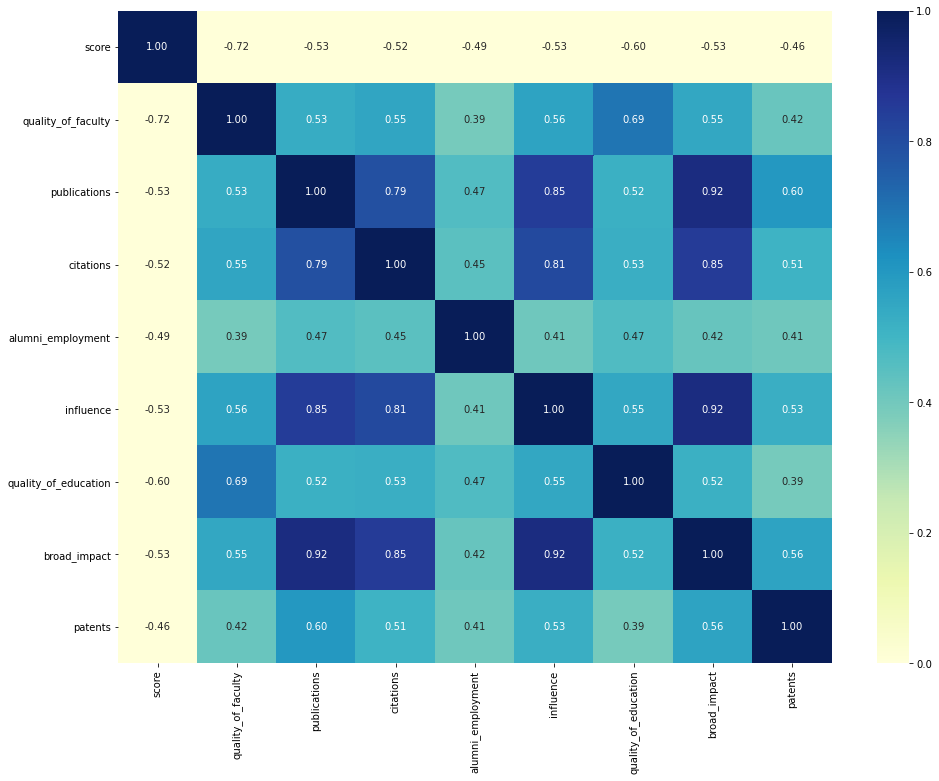

In [328]:
def heatmap(features):
    df = pd.concat([Y, features], axis=1)
    plt.figure(figsize=(16, 12))
    # 获得相关性矩阵，pandas的DataFrame有直接的函数，绘制热力图
    corr_matrix = df[[c for c in df.columns]].corr()
    cg = sns.heatmap(corr_matrix, cmap='YlGnBu', annot=True,
                    fmt='.2f', vmin=0)
heatmap(X)

按照 8:2 随机划分训练集测试集

In [329]:
X_train = X_test = y_train = y_test = None


def datasplit(x, y):
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=20020104)


datasplit(X, Y)
print(len(X_train), len(X_test))


1600 400


## 四、模型构建

In [330]:
# 建立一个字典用于记录各种方法的信息
results = defaultdict(list)

## 1. 原数据+线性回归

直接使用库函数进行回归分析

In [331]:
def skl_LinearRegression():
    #通过sklearn的linear_model创建线性回归对象
    linearRegression = linear_model.LinearRegression()
    #进行训练
    linearRegression.fit(X_train, y_train)
    #通过LinearRegression的coef_属性获得权重向量,intercept_获得b的值
    print("系数:%s,   截距:%.2f" %
          (list(linearRegression.coef_), linearRegression.intercept_))
    return linearRegression.predict(X_test)

skl_lr = skl_LinearRegression()


系数:[-0.0651610201275505, 0.0002108778104276012, -0.0003465771046500258, -0.006295926519482995, 0.0005714645844300825, -0.006654320970929639, -0.002050408734210336, -0.002419180094926366],   截距:65.90


各种性能的评估，以及结果可视化。

通过R2的取值可以更好理解它是如何评价模型好坏的，有这几种取值情况：

- R2_score = 1，达到最大值。即分子为 0 ，意味着样本中预测值和真实值完全相等，没有任何误差。也就是说我们建立的模型完美拟合了所有真实数据，是效果最好的模型，R2_score 值也达到了最大。但通常模型不会这么完美，总会有误差存在，当误差很小的时候，分子小于分母，模型会趋近 1，仍然是好的模型，随着误差越来越大，R2_score 也会离最大值 1 越来越远，直到出现第 2 中情况。

- R2_score = 0。此时分子等于分母，样本的每项预测值都等于均值。也就是说我们辛苦训练出来的模型和均值模型完全一样，还不如不训练，直接让模型的预测值全去均值。当误差越来越大的时候就出现了第三种情况。

- R2_score < 0 ：分子大于分母，训练模型产生的误差比使用均值产生的还要大，也就是训练模型反而不如直接去均值效果好。出现这种情况，通常是模型本身不是线性关系的，而我们误使用了线性模型，导致误差很大。

使用方法：skl's LinearRegression
MSE的值: 15.4831
RMSE的值: 3.9349
MAE的值：2.0387
R2得分: 0.5972


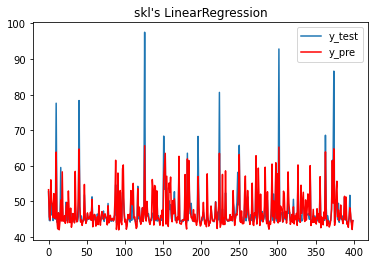

In [332]:
def resultshow(method_name, y_pre):
    global results
    print("使用方法："+method_name)
    #计算出损失函数的值
    mse = np.mean((y_pre - y_test) ** 2)
    rmse = np.sqrt(mse)
    print("MSE的值: %.4f" %mse)
    print("RMSE的值: %.4f" %rmse)
    print("MAE的值：%.4f" % np.mean(np.absolute(y_test-y_pre)))
    r2 = (1-mse/np.var(y_test))
    print("R2得分: %.4f" %r2)
    x_range = range(len(X_test))
    plt.plot(x_range, y_test,label = 'y_test')
    plt.plot(x_range, y_pre, color='r',label ='y_pre')
    plt.legend()
    plt.title(method_name)
    results['method_name'].append(method_name)
    results['RMSE'].append(rmse)
    results['R2'].append(r2)



resultshow("skl's LinearRegression",skl_lr)



发现使用原始数据时，结果并不是很尽人意，同时可以观察到对于**较大得分值**的估计不准确。

现在对多重共线性进行判别，一般判别方法有3种：
- 回归系数的正负号与预期的相反
- 模型的线性关系检验（F检验）显著，但几乎所有回归系数的t检验却不显著
- 容忍度和方差扩大因子VIF（variance inflation factor）大于10

这里使用第三种方法进行检验，$VIF=1/(1-R_i^2)$，其中$R_i^2$是**自变量中的某一变量与除它外剩余的自变量进行多元线性回归，取回归结果**。

即该模型精度来作为这个变量与剩余自变量的相关性，来看看哪个变量对其余变量的解释性高。如果预测程度好，分子将会很小，该变量的VIF将会很大。

注意在使用库模型时，考虑其调用的`OLS`方法是`No constant is added by the model unless you are using formulas`. 所以提前在数据中加入常数项。

In [333]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant

def calVIF(features):
    features = add_constant(features)
    vif = pd.DataFrame()
    vif['Features'] = features.columns
    vif['VIF'] = [variance_inflation_factor(features.values, idx) for idx in range(features.shape[1])]
    print(vif)
calVIF(X)


               Features        VIF
0                 const  15.704096
1    quality_of_faculty   2.173217
2          publications   6.998614
3             citations   3.947513
4     alumni_employment   1.469316
5             influence   6.618447
6  quality_of_education   2.212553
7          broad_impact  12.816281
8               patents   1.637651


下面将从**特征**和**模型**两方面入手，对拟合性能进行提高。

## 2. 舍弃特征+线性回归

通过逐步drop掉相关系数较小但是VIF较大的数据，使得自变量之间的相关性降低。进行线性回归。略有提升，但不显著。
其中一个变化在于所有的系数都是负的了，符合我们的现实逻辑规律。后文将使用舍弃部分特征后的数据。

               Features        VIF
0                 const  15.617855
1    quality_of_faculty   2.143465
2     alumni_employment   1.408082
3             influence   1.839234
4  quality_of_education   2.203283
5               patents   1.499762
系数:[-0.06557971126227079, -0.0064000646627425314, -0.0012101194791238213, -0.0066242519812769836, -0.0026295985123747567],   截距:65.93
使用方法：drop+skl's LinearRegression
MSE的值: 15.5708
RMSE的值: 3.9460
MAE的值：2.0667
R2得分: 0.5949


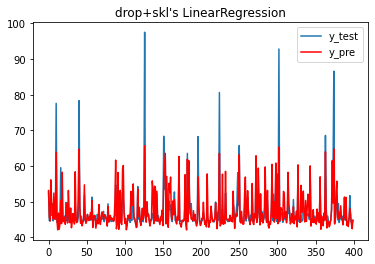

In [334]:
drop_data = X.drop(
    columns=['citations', 'broad_impact', 'publications'])
calVIF(drop_data)
datasplit(drop_data, Y)
resultshow("drop+skl's LinearRegression",skl_LinearRegression())


## 3. 重构特征+线性回归（舍弃）

通过PCA提取主成分，进行线性回归。效果不好，推测原因是特征方差最大的方向并不是与因变量线性关系最强的方向。

系数:[0.0069308451742181015, -0.0037982666129408498, 0.010214635411633895, -0.0019879293505595994, -0.005952005346711867],   截距:47.13
使用方法：pca+skl's LinearRegression
MSE的值: 19.7578
RMSE的值: 4.4450
MAE的值：2.5054
R2得分: 0.4860


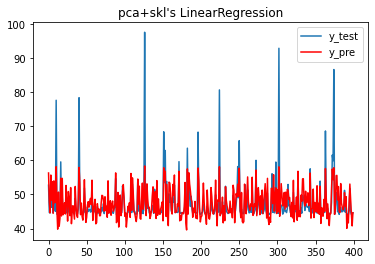

In [335]:
# 使用PCA提取主成分
def myPCA(n, features):
    pca = PCA(n_components=n)
    pca.fit(features)
    return pd.DataFrame(pca.transform(features))


pca_data = myPCA(5, X)
datasplit(pca_data, Y)
resultshow("pca+skl's LinearRegression", skl_LinearRegression())


可以发现在特征方面能做出优化并不显著，下面通过拟合其它回归来进行分析，数据使用原数据。

岭回归（Ridge Regression）和Lasso回归是在普通最小二乘线性回归的基础上加上正则项以对参数进行压缩惩罚。
- 岭回归在OLS回归模型的RSS上加上了惩罚项（l2范数）
- lasso回归的正项则就把二次项改成了一次绝对值（l1范数）

## 4. 舍弃部分特征数据+其它回归模型

系数:[-0.06557967949186827, -0.0064000649045836905, -0.001210120848804239, -0.00662425987864221, -0.0026295989870489885],   截距:65.93
使用方法：skl's Ridge
MSE的值: 15.5708
RMSE的值: 3.9460
MAE的值：2.0667
R2得分: 0.5949


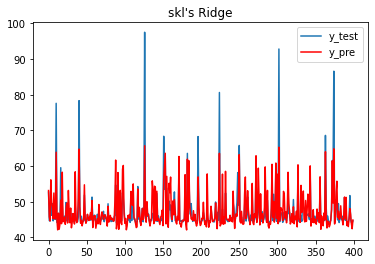

In [336]:
datasplit(drop_data, Y)
def skl_Ridge():
    #通过sklearn的linear_model创建线性回归对象
    ridgeRegression = linear_model.Ridge()
    #进行训练
    ridgeRegression.fit(X_train, y_train)
    #通过LinearRegression的coef_属性获得权重向量,intercept_获得b的值
    print("系数:%s,   截距:%.2f" %
          (list(ridgeRegression.coef_), ridgeRegression.intercept_))
    return ridgeRegression.predict(X_test)


resultshow("skl's Ridge", skl_Ridge())


系数:[-0.0650478571027711, -0.006392270136972272, -0.0012429305288874128, -0.006669391477601076, -0.0026348172475412655],   截距:65.86
使用方法：skl's Lasso
MSE的值: 15.5476
RMSE的值: 3.9430
MAE的值：2.0620
R2得分: 0.5955


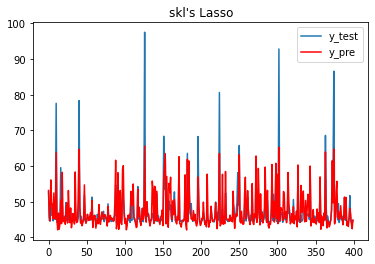

In [337]:
def skl_Lasso():
    #通过sklearn的linear_model创建线性回归对象
    lassoRegression = linear_model.Lasso()
    #进行训练
    lassoRegression.fit(X_train, y_train)
    #通过LinearRegression的coef_属性获得权重向量,intercept_获得b的值
    print("系数:%s,   截距:%.2f" %
          (list(lassoRegression.coef_), lassoRegression.intercept_))
    return lassoRegression.predict(X_test)


resultshow("skl's Lasso", skl_Lasso())


可以发现，无论何种模型对该数据的回归分析都没有明显的提高，推测是数据本身分布并不适合线性模型。

绘制分数与最明显特征的分布图，发现数据存在以下两点特征：
- 更像是x与 y的n次方 的线性组合
- 60分左右存在着明显的线性分界

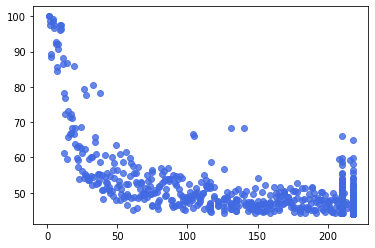

In [338]:
plt.plot(X['quality_of_faculty'], Y, 'ro', color='#4169E1',
         alpha=0.8, linewidth=1)
u = np.mean(Y)
st = np.std(Y)


## 5. 剔除离群值数据+线性回归

经过和他人讨论和再次思考后，提出如下三种解决方案：
- 通过z-score剔除离群值，但这种做法相当于忽视了高分学校的存在，并不是很好
- 拟合x与 y的n次方 的线性组合
- 分段拟合，有点类似于决策树，不再尝试

系数:[-0.0323965213524152, -0.0005417995046481574, -0.0005512881328150945, -0.0037548086060466682, -0.0005510691211306154, -0.004051747543431086, -0.0016979148319275835, -0.001820810822068673],   截距:57.87
使用方法：cutdata+skl's LinearRegression
MSE的值: 3.9645
RMSE的值: 1.9911
MAE的值：1.1797
R2得分: 0.6590


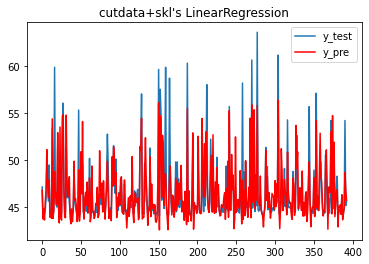

In [339]:
# 通过z-score剔除离群值
def detect_outliers():
    mean_d = np.mean(Y)
    std_d = np.std(Y)
    return np.where((Y-mean_d)/std_d>3.5)


# function_vector = np.vectorize(detect_outliers)
# fine_X = function_vector(np.array(X))
todel = list(detect_outliers()[0]+200)
datasplit(X.drop(todel, axis=0), Y.drop(todel, axis=0))
resultshow("cutdata+skl's LinearRegression", skl_LinearRegression())


## 6. 次方拟合+线性回归

将X进行1/64开根，然后拟合。

系数:[-319.9163560832382, -109.20161044313764, -50.9200735311177, -69.33926694491666, -50.728403891869085],   截距:700.39
使用方法：pow+skl's LinearRegression
MSE的值: 5.2826
RMSE的值: 2.2984
MAE的值：1.4240
R2得分: 0.8626


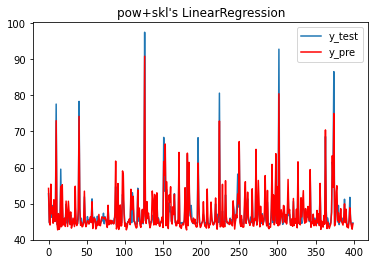

In [340]:
# 拟合x与 y的n次方 的线性组合 -> x的n次根 和y的线性组合

datasplit(np.power(drop_data,1/64), Y)
resultshow("pow+skl's LinearRegression", skl_LinearRegression())


## 7. 加入离散值+线性回归

将地区因素考虑进来。根据地区学校的平均得分，将拔尖学校划分为第一档次，其余学校为第二档次。发现效果有所提升。

因为地区是离散值，猜测作为档次划分标准，拟合到方程的系数中也许会有更好的效果。

In [341]:
feature_cols = ['quality_of_faculty', 'publications', 'citations', 'alumni_employment', 
                'influence', 'quality_of_education', 'broad_impact', 'patents', 'region']
X = data_df[feature_cols]
Y = data_df['score']
places = X['region'].unique()
len(places)


59

In [342]:
for place in places:
    idxs = X[X['region']==place].index
    avg = np.mean(Y.loc[idxs])
    if avg >= 50:
        tmp = 1
    else:
        tmp = 1024
    X = X.replace(place,tmp)


系数:[-0.06466928069850218, -0.00030879359411657085, -0.0002577258387367274, -0.006100786594901265, 0.0007750584816981537, -0.006705427669364033, -0.0017661837300681036, -0.0022782498836380893, -0.0004618424339327549],   截距:66.01
使用方法：adddata+skl's LinearRegression
MSE的值: 15.3475
RMSE的值: 3.9176
MAE的值：2.0389
R2得分: 0.6007


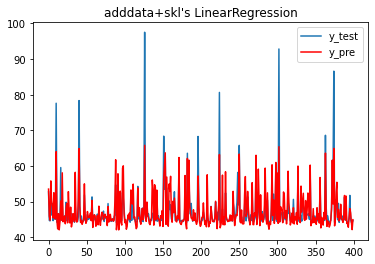

In [343]:
datasplit(X, Y)
resultshow("adddata+skl's LinearRegression", skl_LinearRegression())


## 五、分析与总结

对线性回归模型的系数进行分析：
- 系数的正/负代表了该因素对最终结果起到正/反作用影响。随着该因素的增长，最终结果是正/负增长
- 系数的大小代表了斜率，也就是该因素对结果的影响大小。随着该因素的变化，系数绝对值越大的对结果影响越大。

以5.中“线性”回归分析结果为例，所有系数都是负的，说明任何指标变小（排名靠前），都会引起结果的变大（得分变高）。

绘制饼图，展示各个因素的重要性，可以看出师资力量起到了关键性作用，校友就业其次。


Text(0.5, 1.0, 'Pie chart')

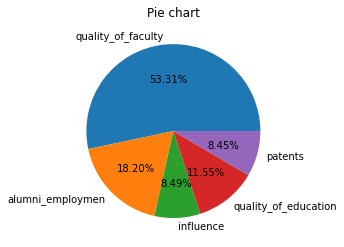

In [344]:

labels = ['quality_of_faculty', 'alumni_employmen',
          'influence', 'quality_of_education', 'patents']
X = [abs(i) for i in [-319.9163560832382, -109.20161044313764, -
     50.9200735311177, -69.33926694491666, -50.728403891869085]]

fig = plt.figure()
plt.pie(X, labels=labels, autopct='%1.2f%%')  # 画饼图（数据，数据对应的标签，百分数保留两位小数点）
plt.title("Pie chart")


本次实验尝试了7种不同的数据处理和回归模型组合，完整的体验了线性回归的流程，对函数的使用和理解加深。但因为数据的分布问题，认为很难将模型优化至更好的线性模型，推测曲线或分段函数将更适合该数据。

尝试方案和结果如下所示，其中去除过高值和拟合处理过数据的曲线两种方法最优：

In [345]:
print([it for it in results.items()])

[('method_name', ["skl's LinearRegression", "drop+skl's LinearRegression", "pca+skl's LinearRegression", "skl's Ridge", "skl's Lasso", "cutdata+skl's LinearRegression", "pow+skl's LinearRegression", "adddata+skl's LinearRegression"]), ('RMSE', [3.934856491129311, 3.945980074065441, 4.444969151015766, 3.945979940003814, 3.9430470699570535, 1.9910950834769312, 2.2983967919556423, 3.9175889040949388]), ('R2', [0.5971917781300208, 0.5949111338648685, 0.4859823479880885, 0.5949111613900311, 0.5955131063661407, 0.6589694839609244, 0.8625671525615146, 0.6007193600639427])]


## 六、参考资料
- [【机器学习12】线性回归算法评价指标：MSE、RMSE、R2_score - 简书 (jianshu.com)](https://www.jianshu.com/p/f7309124cacf)
- [Variance Inflation Factor (VIF) - Overview, Formula, Uses (corporatefinanceinstitute.com)](https://corporatefinanceinstitute.com/resources/knowledge/other/variance-inflation-factor-vif/#:~:text=Variance)

- [机器学习总结(一)：线性回归、岭回归、Lasso回归_她说巷尾的樱花开了的博客-CSDN博客_lasso回归](https://blog.csdn.net/hzw19920329/article/details/77200475)
- [线性回归中的多重共线性与岭回归 - 知乎 (zhihu.com)](https://zhuanlan.zhihu.com/p/336672294)
- [线性回归中的共线性问题 - 简书 (jianshu.com)](https://www.jianshu.com/p/a296604e651f)
- [数据标准化（一） - Z-Score标准化 - 知乎 (zhihu.com)](https://zhuanlan.zhihu.com/p/69074703)
- [在numpy中，对数组或矩阵中的每个元素，进行函数计算_希铭的博客-CSDN博客_numpy对每一行进行函数计算](https://blog.csdn.net/hawkuu/article/details/103425110)